In [ ]:
%load_ext autoreload
%autoreload 2

## Installation
If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.

In [ ]:
%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

Cloning into 'Pearl'...
remote: Enumerating objects: 6409, done.
remote: Counting objects: 100% (1729/1729), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 6409 (delta 1516), reused 1402 (delta 1352), pack-reused 4680 (from 1)
Receiving objects: 100% (6409/6409), 55.11 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (4391/4391), done.
/content/Pearl
Processing /content/Pearl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 62.2 MB/s eta 0:00:00
  Created wheel for Pearl: filename=Pearl-0.1.0-py3-none-any.whl siz

## Import Modules

In [ ]:
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.action_representation_modules.one_hot_action_representation_module import OneHotActionTensorRepresentationModule
from pearl.replay_buffers import BasicReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.utils.uci_data import download_uci_data
from pearl.utils.instantiations.environments.contextual_bandit_uci_environment import (
    SLCBEnvironment,
)
from pearl.policy_learners.exploration_modules.contextual_bandits.squarecb_exploration import SquareCBExploration
from pearl.policy_learners.exploration_modules.contextual_bandits.ucb_exploration import (
    UCBExploration,
)
from pearl.policy_learners.exploration_modules.contextual_bandits.thompson_sampling_exploration import (
    ThompsonSamplingExplorationLinear,
)
from pearl.policy_learners.contextual_bandits.neural_bandit import NeuralBandit
from pearl.policy_learners.contextual_bandits.neural_linear_bandit import (
    NeuralLinearBandit,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

set_seed(0)

## Load Environment
The environment which underlies the experiments to follow is a contextual bandit environment we added to Pearl that allows us to use UCI datasets (https://archive.ics.uci.edu/datasets).

The UCI datasets span a wide variety of prediction tasks. We use these tasks to construct a contexual bandit environment in which an agent receives an expected reward of 1 if it correctly labels a data point and 0 otherwise. Pearl currently supports the following datasets: pendigits, letter, satimage, yeast. Additional ones can be readily added.

In the following experiment we will test different types of contextual bandits algorithms on the pendigits UCI dataset.

In [ ]:
# load environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download UCI dataset if doesn't exist
uci_data_path = "./utils/instantiations/environments/uci_datasets"
if not os.path.exists(uci_data_path):
    os.makedirs(uci_data_path)
    download_uci_data(data_path=uci_data_path)

# Built CB environment using the pendigits UCI dataset
pendigits_uci_dict =  {
    "path_filename": os.path.join(uci_data_path, "pendigits/pendigits.tra"),
    "action_embeddings": "discrete",
    "delim_whitespace": False,
    "ind_to_drop": [],
    "target_column": 16,
}
env = SLCBEnvironment(**pendigits_uci_dict)

# experiment code
number_of_steps = 10000
record_period = 400

/usr/local/lib/python3.10/dist-packages/pearl/utils/instantiations/environments/contextual_bandit_uci_environment.py:52: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=delim_whitespace, header=None)
/usr/local/lib/python3.10/dist-packages/pearl/utils/instantiations/environments/contextual_bandit_uci_environment.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       8
1       2
2       1
3       4
4       1
       ..
7489    5
7490    4
7491    5
7492    1
7493    7
Name: 0, Length: 7494, dtype: category
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 0] = df.iloc[:, 0].astype("category")


## Contextual Bandits learners
The following sections show how to implement the neural versions of SquareCB, LinUCB and LinTS with Pearl.

## Contextual Bandits learners: SquareCB

The SquareCB algorithm requires only a regression model with which it learns the reward function. Given the reward model, SquareCB executes the following policy:
$$
\widehat{a}_*\in \arg\max_a\widehat{r}(x,a)\\
\widehat{r}_*\in \max_a\widehat{r}(x,a)\\
\text{If $a\neq \widehat{a}_*$}: \pi(a,x)= \frac{1}{A + \gamma (\widehat{r}_* - \widehat{r}(x,a))}\\
\text{If $a= \widehat{a}_*$}: \pi(a,x) = 1-\sum_{a'\neq \widehat{a}_*}\pi(a',x).
$$
This policy balances exploration and exploitation in an intelligent way.

To use the SquareCB algrorithm in Pearl we set the policy learner as `NeuralBandit`. `NeuralBandit` is class supportings the estimation of the reward function with a neural architecture. With access to an estimated reward model, we then use an instance of `SquareCBExploration` as an exploration module.

To further highlight the versatility of the modular design of Pearl, we use the `OneHotActionTensorRepresentationModule` as the action representation module. This module internally converts actions from integers to one-hot-encoded vectors.


episode 100, step 100, agent=PearlAgent with NeuralBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: -0.02050408534705639
episode 200, step 200, agent=PearlAgent with NeuralBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: -0.039917074143886566
episode 300, step 300, agent=PearlAgent with NeuralBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0325154066085815
episode 400, step 400, agent=PearlAgent with NeuralBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0192910432815552
episode 500, step 500, agent=PearlAgent with NeuralBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.020320570096373558
episode 600, step 600, agent=PearlAgent with NeuralBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0140972137451172
episode 700, step 700, agent=PearlAgent with NeuralBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
retur

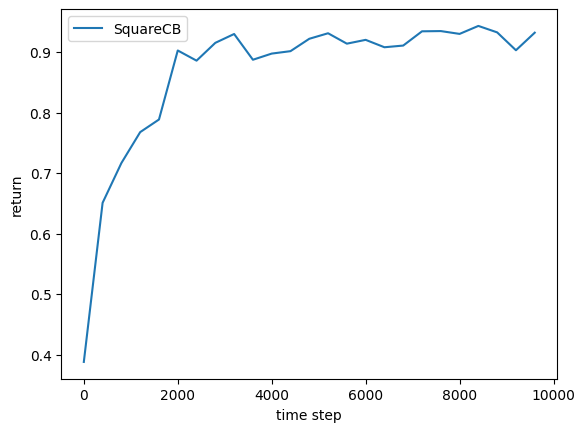

In [ ]:
# Create a Neural SquareCB pearl agent with 1-hot action representation
action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env.unique_labels_num,
)

agent = PearlAgent(
    policy_learner=NeuralBandit(
        feature_dim = env.observation_dim + env.unique_labels_num,
        hidden_dims=[64, 16],
        training_rounds=10,
        learning_rate=0.01,
        action_representation_module=action_representation_module,
        exploration_module= SquareCBExploration(gamma = env.observation_dim * env.unique_labels_num * number_of_steps)
    ),
    replay_buffer=BasicReplayBuffer(100_000),
    device_id=-1,
)


info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "SquareCB-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="SquareCB")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Contextual Bandits learners: LinUCB

Next, we describe how to use the neural version of the LinUCB algorithm with Pearl, which uses UCB type of exploration with neural architectures. LinUCB and its neural version are generalizations of the seminal Upper Confidence Bound (UCB) algorithm. Both execute a policy of the following form:
$$
\pi(a,x) \in \arg\max_a \widehat{r}(x,a) + \mathrm{score}(x,a),
$$
that is, both use a function that estimates the expected reward with an additional bonus term that quantifies the potential of choosing an action given a certain context. A common way to estimate the score function in the linear case with features $\phi(x,a)$ is:
$$
\mathrm{score}(x,a) = \alpha ||\phi(x,a) ||_{A^{-1}}\\
\text{where } A= \lambda I + \sum_{n\leq t} \phi(x_n,a_n)\phi^T(x_n,a_n).
$$

To implement the LinUCB algorithm in Pearl, use the `NeuralLinearBandit` policy learner module. This module supports (i) learning a reward model, and (ii) calculating a score function by estimating the uncertainty using the last layer features. Further, we set the exploration module to an instance of  `UCBExploration` and set the `alpha` hyper-parameter to enable the agent with the UCB-like update rule.


episode 100, step 100, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.20280151069164276
episode 200, step 200, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.054456718266010284
episode 300, step 300, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: -0.13178661465644836
episode 400, step 400, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.9865397214889526
episode 500, step 500, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.14140896499156952
episode 600, step 600, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 1.1187363862991333
episode 700, step 700, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=

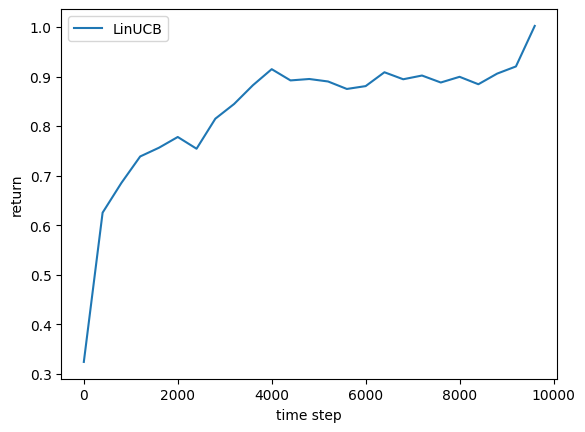

In [ ]:

# Create a Neural LinUCB pearl agent with 1-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralLinearBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        state_features_only=False,
        training_rounds=10,
        learning_rate=0.01,
        action_representation_module=action_representation_module,
        exploration_module= UCBExploration(alpha=1.0)
    ),
    replay_buffer=BasicReplayBuffer(100_000),
    device_id=-1,
)


info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "LinUCB-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="LinUCB")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Contextual Bandits learners: Linear Thompson Sampling

Lastly, we describe how to use the neural version of the Linear Thompson Sampling (LinTS) algorithm with Pearl. The algorithm which uses Thompson sampling exploration with neural architectures. The LinTS sampling is closely related to the LinUCB algorithm, with a key modification that often improves its convergence in practice: sample the score function from a probability, instead of fixing it determinstically. Practically, this often reduces the over-exploring of arms, since the score may be smaller than in the LinUCB algorithm.

To implement the LinTS algorithm in Pearl, use the `NeuralLinearBandit` policy learner module combined with an exploration module of type `ThompsonSamplingExplorationLinear`. This enables the agent to sample the score based on its estimated uncertainty, rather than to fix it as in LinUCB algorithm.


episode 100, step 100, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.09024851769208908
episode 200, step 200, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.002633035881444812
episode 300, step 300, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: -0.07467412203550339
episode 400, step 400, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 1.0156103372573853
episode 500, step 500, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 1.04409921169281
episode 600, step 600, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Contextual bandits with CB datasets
return: 0.9837733507156372
episode 700, step 700, agent=PearlAgent with NeuralLinearBandit, BasicReplayBuffer, env=Con

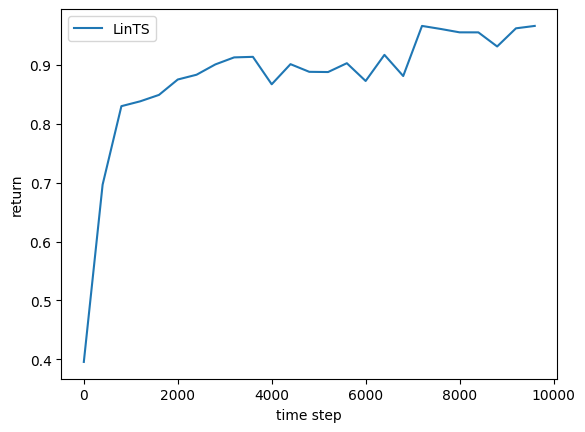

In [ ]:
# Create a Neural LinTS pearl agent with 1-hot action representation

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env._action_space.n,
)

agent = PearlAgent(
    policy_learner=NeuralLinearBandit(
        feature_dim = env.observation_dim + env._action_space.n,
        hidden_dims=[64, 16],
        state_features_only=False,
        training_rounds=10,
        learning_rate=0.01,
        action_representation_module=action_representation_module,
        exploration_module= ThompsonSamplingExplorationLinear()
    ),
    replay_buffer=BasicReplayBuffer(100_000),
    device_id=-1,
)

info = online_learning(
    agent=agent,
    env=env,
    number_of_steps=number_of_steps,
    print_every_x_steps=100,
    record_period=record_period,
    learn_after_episode=True,
)
torch.save(info["return"], "LinTS-return.pt")
plt.plot(record_period * np.arange(len(info["return"])), info["return"], label="LinTS")
plt.xlabel("time step")
plt.ylabel("return")
plt.legend()
plt.show()

## Summary
In this example, we showed how to use popular contextual bandits algorithms in Pearl.